<center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">به نام خدا</div></center>
<img src= alt="class.vision" style="width: 200px;"/>
<h1><center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">Image captioning با Attention</div></center></h1>

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [ ]:
try:

  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
       
        print(e)



import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

2025-06-03 17:28:41.591416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.14.0.600


2025-06-03 17:28:43.155617: E tensorflow/compiler/xla/stream_executor/rocm/rocm_driver.cc:302] failed call to hipInit: HIP_ERROR_NoDevice
2025-06-03 17:28:43.155650: I tensorflow/compiler/xla/stream_executor/rocm/rocm_diagnostics.cc:111] retrieving ROCM diagnostic information for host: gpu3-main
2025-06-03 17:28:43.155656: I tensorflow/compiler/xla/stream_executor/rocm/rocm_diagnostics.cc:118] hostname: gpu3-main
2025-06-03 17:28:43.155710: I tensorflow/compiler/xla/stream_executor/rocm/rocm_diagnostics.cc:141] librocm reported version is: NOT_FOUND: was unable to find librocm.so DSO loaded into this program
2025-06-03 17:28:43.155716: I tensorflow/compiler/xla/stream_executor/rocm/rocm_diagnostics.cc:145] kernel reported version is: UNIMPLEMENTED: kernel reported driver version not implemented


## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [2]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014_extracted/train2014/'
else:
  PATH = os.path.abspath('.')+'/train2014_extracted/train2014/'

## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [ ]:

with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)


train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)


num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [ ]:
from transformers import ViTImageProcessor, TFViTModel

VIT_MODEL_NAME = "google/vit-base-patch16-224"
IMG_SIZE = 224
PATCH_SIZE = 16

try:
    vit_processor = ViTImageProcessor.from_pretrained(VIT_MODEL_NAME)
    
    vit_image_processor = ViTImageProcessor.from_pretrained(VIT_MODEL_NAME)
    vit_model = TFViTModel.from_pretrained(VIT_MODEL_NAME)
    vit_model.trainable = False 
    print("ViTImageProcessor berhasil dimuat.")
    print(f"ViT Processor dan Model ('{VIT_MODEL_NAME}') berhasil dimuat dan dibekukan.")
except ModuleNotFoundError as e_mod:
    print(f"Error modul setelah restart: {e_mod}")
    print("Jika masih error, mungkin ada masalah environment yang lebih dalam.")
except Exception as e:
    print(f"Gagal memuat komponen ViT setelah restart: {e}.")

/home/jupyter-c14220344@john.pet-5348a/.conda/envs/tf-roy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-03 17:28:52.006401: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.007239: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.007883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.095179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.095705: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.096494: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.097145: I tensorflow/core/common_ru

ViTImageProcessor berhasil dimuat.
ViT Processor dan Model ('google/vit-base-patch16-224') berhasil dimuat dan dibekukan.


In [5]:
def load_and_preprocess_image_for_vit(image_path_str):
    try:
        img = Image.open(image_path_str).convert("RGB")
        processed_inputs = vit_image_processor(images=img, return_tensors="tf")
        img_tensor = processed_inputs['pixel_values']
        return img_tensor, image_path_str
    except Exception as e:
        print(f"Error loading/processing image {image_path_str}: {e}")
        return None, image_path_str

NUM_PATCHES = (IMG_SIZE // PATCH_SIZE)**2
VIT_FEATURE_DIM = vit_model.config.hidden_size
print(f"ViT Config: Num Patches (setelah CLS token dihilangkan nanti) = {NUM_PATCHES}, Hidden Size = {VIT_FEATURE_DIM}")


ViT Config: Num Patches (setelah CLS token dihilangkan nanti) = 196, Hidden Size = 768


In [ ]:

BASE_DIR = os.path.abspath('.')
VIT_FEATURES_DIR = os.path.join(BASE_DIR, 'features_vit_transformer_model') # Nama dir baru
if not os.path.exists(VIT_FEATURES_DIR):
    os.makedirs(VIT_FEATURES_DIR)
    print(f"Direktori '{VIT_FEATURES_DIR}' dibuat.")

encode_train_paths = sorted(list(set(img_name_vector)))
print(f"Jumlah gambar unik untuk ekstraksi fitur: {len(encode_train_paths)}")

all_features_exist = True
if not encode_train_paths:
    all_features_exist = True
else:
    for img_path in encode_train_paths:
        path_of_feature = os.path.join(VIT_FEATURES_DIR, os.path.basename(img_path) + '.npy')
        if not os.path.exists(path_of_feature):
            all_features_exist = False
            break

import gc

if not all_features_exist:
    print(f"Memulai caching fitur ViT ke '{VIT_FEATURES_DIR}'...")
    image_dataset_caching = tf.data.Dataset.from_tensor_slices(encode_train_paths)
    image_dataset_caching = image_dataset_caching.map(
        lambda x: tf.numpy_function(load_and_preprocess_image_for_vit, [x], [tf.float32, tf.string]),
        num_parallel_calls=1
    ).batch(1)

    processed_count_cache = 0
    total_to_cache = len(encode_train_paths)
    start_time_cache = time.time()
    if total_to_cache > 0:
        for batch_idx_cache, (img_batch_cache, path_batch_cache) in enumerate(image_dataset_caching):
            current_path_str_cache = path_batch_cache.numpy()[0].decode('utf-8')
            if (batch_idx_cache + 1) % 100 == 0 or (batch_idx_cache + 1) == 1 or (batch_idx_cache + 1) == total_to_cache:
                print(f"  Caching: {batch_idx_cache + 1}/{total_to_cache} - {current_path_str_cache.split('/')[-1]}")

            if img_batch_cache is None or img_batch_cache.shape[0] == 0: continue
            img_input_vit_cache = tf.squeeze(img_batch_cache, axis=1) if len(img_batch_cache.shape) == 5 else img_batch_cache
            if len(img_input_vit_cache.shape) != 4: continue

            try:
                vit_output_cache = vit_model(img_input_vit_cache, training=False)
                patch_features_cache = vit_output_cache.last_hidden_state[:, 1:, :] # (1, NUM_PATCHES, VIT_FEATURE_DIM)
                feature_to_save_cache = patch_features_cache[0].numpy()
                save_path_cache = os.path.join(VIT_FEATURES_DIR, os.path.basename(current_path_str_cache) + '.npy')
                np.save(save_path_cache, feature_to_save_cache)
                processed_count_cache += 1
            except Exception as e_c: print(f"    Error caching {current_path_str_cache}: {e_c}")
            if (batch_idx_cache + 1) % 200 == 0: gc.collect()
        print(f"Caching ViT selesai. {processed_count_cache}/{total_to_cache} fitur disimpan. Waktu: {(time.time()-start_time_cache)/60:.2f} m")
    else: print("Tidak ada gambar untuk di-cache.")
else:
    print(f"Semua fitur ViT sudah ada di '{VIT_FEATURES_DIR}'.")

2025-06-03 17:28:52.747502: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.748768: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.766260: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.767226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.768103: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.768893: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.769442: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.780092: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52.780752: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:52

Jumlah gambar unik untuk ekstraksi fitur: 25950
Memulai caching fitur ViT ke '/home/jupyter-c14220344@john.pet-5348a/new/features_vit_transformer_model'...
  Caching: 1/25950 - COCO_train2014_000000000025.jpg


2025-06-03 17:28:53.027729: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:53.030229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:53.030825: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:53.036648: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:53.037200: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:53.038861: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:53.049463: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:53.050156: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:53.050901: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 17:28:53

  Caching: 100/25950 - COCO_train2014_000000002496.jpg
  Caching: 200/25950 - COCO_train2014_000000005028.jpg
  Caching: 300/25950 - COCO_train2014_000000007361.jpg
  Caching: 400/25950 - COCO_train2014_000000009599.jpg
  Caching: 500/25950 - COCO_train2014_000000011812.jpg
  Caching: 600/25950 - COCO_train2014_000000013920.jpg
  Caching: 700/25950 - COCO_train2014_000000015927.jpg
  Caching: 800/25950 - COCO_train2014_000000018309.jpg
  Caching: 900/25950 - COCO_train2014_000000020888.jpg
  Caching: 1000/25950 - COCO_train2014_000000023434.jpg
  Caching: 1100/25950 - COCO_train2014_000000025777.jpg
  Caching: 1200/25950 - COCO_train2014_000000027627.jpg
  Caching: 1300/25950 - COCO_train2014_000000029716.jpg
  Caching: 1400/25950 - COCO_train2014_000000032061.jpg
  Caching: 1500/25950 - COCO_train2014_000000034151.jpg
  Caching: 1600/25950 - COCO_train2014_000000036500.jpg
  Caching: 1700/25950 - COCO_train2014_000000038934.jpg
  Caching: 1800/25950 - COCO_train2014_000000041135.jpg
 

In [ ]:

top_k_tokenizer = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k_tokenizer, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_sequences = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
caption_vectors = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post')
max_caption_length = caption_vectors.shape[1]
vocab_size_effective = len(tokenizer.word_index) + 1 
print(f"Max caption length: {max_caption_length}")
print(f"Effective vocabulary size: {vocab_size_effective}")

Max caption length: 49
Effective vocabulary size: 8236


In [8]:
img_names_train_split, img_names_val_split, caps_train_split, caps_val_split = train_test_split(
    img_name_vector, caption_vectors, test_size=0.2, random_state=0
)
print(f"Training set: {len(img_names_train_split)} images, Validation set: {len(img_names_val_split)} images")



Training set: 24000 images, Validation set: 6000 images


In [ ]:

D_MODEL_TRANSFORMER = 256  
NUM_DECODER_LAYERS_TRANSFORMER = 4
NUM_HEADS_TRANSFORMER = 8
DFF_FEED_FORWARD_TRANSFORMER = 512 
DROPOUT_RATE_TRANSFORMER = 0.1
BATCH_SIZE_FOR_TRAINING = 32 
BUFFER_SIZE_SHUFFLE = 1000


GRID_SIZE_ATTENTION_PLOT = int(np.sqrt(NUM_PATCHES))
if GRID_SIZE_ATTENTION_PLOT**2 != NUM_PATCHES:
    print(f"Peringatan: NUM_PATCHES ({NUM_PATCHES}) bukan kuadrat sempurna. Plotting attention mungkin kurang akurat.")


def load_cached_vit_features_map_func(img_name_tensor_bytes, cap_numpy_array): 
    img_name_str = img_name_tensor_bytes.decode('utf-8') 
    
    feature_path = os.path.join(VIT_FEATURES_DIR, os.path.basename(img_name_str) + '.npy')
    try:
        vit_feature_sequence = np.load(feature_path)
        

        return vit_feature_sequence.astype(np.float32), cap_numpy_array.astype(np.int32) 
    except FileNotFoundError:
        print(f"File fitur tidak ditemukan: {feature_path}. Mengembalikan zeros.")
        # Kembalikan array zeros dengan bentuk yang diharapkan
        return np.zeros((NUM_PATCHES, VIT_FEATURE_DIM), dtype=np.float32), cap_numpy_array.astype(np.int32) 
    except Exception as e:
        print(f"Error saat memuat fitur {feature_path}: {e}. Mengembalikan zeros.")
        return np.zeros((NUM_PATCHES, VIT_FEATURE_DIM), dtype=np.float32), cap_numpy_array.astype(np.int32) 



dataset_train_transformer = tf.data.Dataset.from_tensor_slices((img_names_train_split, caps_train_split))
dataset_train_transformer = dataset_train_transformer.map(lambda item1, item2: tf.numpy_function(
    load_cached_vit_features_map_func, 
    [item1, item2], 
    [tf.float32, tf.int32] 
), num_parallel_calls=tf.data.experimental.AUTOTUNE)


def set_shapes(features, captions):
    features.set_shape([NUM_PATCHES, VIT_FEATURE_DIM]) 
    captions.set_shape([max_caption_length]) 
    return features, captions

dataset_train_transformer = dataset_train_transformer.map(set_shapes)

dataset_train_transformer = dataset_train_transformer.shuffle(BUFFER_SIZE_SHUFFLE)

dataset_train_transformer = dataset_train_transformer.batch(BATCH_SIZE_FOR_TRAINING, drop_remainder=True) 
dataset_train_transformer = dataset_train_transformer.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding_val = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding_val, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, tokenizer.word_index['<pad>']), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

class MultiHeadAttentionTF(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttentionTF, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q); k = self.wk(k); v = self.wv(v)
        q = self.split_heads(q, batch_size); k = self.split_heads(k, batch_size); v = self.split_heads(v, batch_size)
        
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        output = self.dense(output)
        return output, attention_weights

def point_wise_feed_forward(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttentionTF(d_model, num_heads)
        self.mha2 = MultiHeadAttentionTF(d_model, num_heads)
        self.ffn = point_wise_feed_forward(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask_enc):
 
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask_enc)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

class TransformerCaptionDecoder(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, max_seq_len_pos_encoding, rate=0.1):
        super(TransformerCaptionDecoder, self).__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_seq_len_pos_encoding, d_model)
        self.decoder_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.final_dense_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, target_caption_tokens, adapted_vit_encoder_output, training):
        seq_len = tf.shape(target_caption_tokens)[1]
        

        look_ahead_m = create_look_ahead_mask(seq_len)
        dec_target_padding_m = create_padding_mask(target_caption_tokens)
        combined_m = tf.maximum(dec_target_padding_m, look_ahead_m)
       
        enc_padding_m = None 


        x = self.embedding(target_caption_tokens) 
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        attention_weights_all_layers = {}
        for i, layer in enumerate(self.decoder_layers):
            x, block1_att, block2_att = layer(x, adapted_vit_encoder_output, training, combined_m, enc_padding_m)
            attention_weights_all_layers[f'decoder_layer{i+1}_self_att'] = block1_att
            attention_weights_all_layers[f'decoder_layer{i+1}_cross_att_img'] = block2_att
        
        predictions = self.final_dense_layer(x) 
        return predictions, attention_weights_all_layers


class ViTFeaturesProjection(tf.keras.Model): 
    def __init__(self, target_d_model_for_transformer):
        super(ViTFeaturesProjection, self).__init__()
        
        self.projection_layer = tf.keras.layers.Dense(target_d_model_for_transformer, activation='relu')

    def call(self, raw_vit_patch_features, training=False): 
        return self.projection_layer(raw_vit_patch_features)


vit_feature_projector = ViTFeaturesProjection(D_MODEL_TRANSFORMER)
caption_transformer_decoder = TransformerCaptionDecoder(
    num_layers=NUM_DECODER_LAYERS_TRANSFORMER,
    d_model=D_MODEL_TRANSFORMER,
    num_heads=NUM_HEADS_TRANSFORMER,
    dff=DFF_FEED_FORWARD_TRANSFORMER,
    target_vocab_size=vocab_size_effective,
    max_seq_len_pos_encoding=max_caption_length,
    rate=DROPOUT_RATE_TRANSFORMER
)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32) 
        self.warmup_steps = float(warmup_steps) 

    def __call__(self, step):
        step = tf.cast(step, tf.float32) 
        
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
 
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


learning_rate_schedule = CustomSchedule(D_MODEL_TRANSFORMER)
optimizer_tr = tf.keras.optimizers.Adam(
    learning_rate_schedule, 
    beta_1=0.9, 
    beta_2=0.98, 
    epsilon=1e-9
)

loss_object_tr = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, tokenizer.word_index['<pad>']))
    loss_ = loss_object_tr(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


checkpoint_dir_tr = './checkpoints_full_transformer_v2'
ckpt_tr = tf.train.Checkpoint(vit_feature_projector=vit_feature_projector,
                              caption_transformer_decoder=caption_transformer_decoder,
                              optimizer=optimizer_tr)
ckpt_manager_tr = tf.train.CheckpointManager(ckpt_tr, checkpoint_dir_tr, max_to_keep=5)
start_epoch_tr = 0
if ckpt_manager_tr.latest_checkpoint:
    ckpt_tr.restore(ckpt_manager_tr.latest_checkpoint)
    start_epoch_tr = int(ckpt_manager_tr.latest_checkpoint.split('-')[-1])
    print(f"Checkpoint Transformer '{ckpt_manager_tr.latest_checkpoint}' restored, starting from epoch {start_epoch_tr+1}")


@tf.function
def train_step_transformer_model(cached_vit_features, target_caption_seq):
   
    tar_input = target_caption_seq[:, :-1] 
    tar_real_output = target_caption_seq[:, 1:]  

    with tf.GradientTape() as tape:
        projected_vit_features = vit_feature_projector(cached_vit_features, training=True)
        predictions, _ = caption_transformer_decoder(tar_input, projected_vit_features, training=True)
        loss = masked_loss_function(tar_real_output, predictions)

    trainable_vars_tr = vit_feature_projector.trainable_variables + caption_transformer_decoder.trainable_variables
    gradients_tr = tape.gradient(loss, trainable_vars_tr)
    optimizer_tr.apply_gradients(zip(gradients_tr, trainable_vars_tr))
    return loss


2025-06-03 22:02:30.951023: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:02:30.955153: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


In [ ]:

EPOCHS_TRANSFORMER = 20 
train_loss_history_tr = []
num_steps_per_epoch_tr = len(img_names_train_split) // BATCH_SIZE_FOR_TRAINING
if len(img_names_train_split) % BATCH_SIZE_FOR_TRAINING != 0: num_steps_per_epoch_tr +=1

print(f"\nMemulai Training Model Full Transformer dari epoch {start_epoch_tr + 1}...")
for epoch_tr in range(start_epoch_tr, EPOCHS_TRANSFORMER):
    epoch_start_time_tr = time.time()
    total_epoch_loss_val_tr = 0.0

    for (batch_num_tr, (vit_feat_batch, target_cap_batch)) in enumerate(dataset_train_transformer):
        batch_loss_tr = train_step_transformer_model(vit_feat_batch, target_cap_batch)
        total_epoch_loss_val_tr += batch_loss_tr

        if batch_num_tr % 50 == 0:
            print(f'  Epoch {epoch_tr + 1} Batch {batch_num_tr}/{num_steps_per_epoch_tr} Loss: {batch_loss_tr.numpy():.4f}')
    
    avg_epoch_loss_val_tr = total_epoch_loss_val_tr / num_steps_per_epoch_tr
    train_loss_history_tr.append(avg_epoch_loss_val_tr.numpy())

    if (epoch_tr + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager_tr.save()
        print(f'  Checkpoint disimpan untuk epoch {epoch_tr+1} di {ckpt_save_path}')

    print(f'Epoch {epoch_tr + 1} Avg. Loss: {avg_epoch_loss_val_tr.numpy():.4f}, Time: {time.time() - epoch_start_time_tr:.2f} sec\n')


def evaluate_caption_transformer(image_path_str_eval):
    max_gen_len = max_caption_length 
    img_tensor_eval, _ = load_and_preprocess_image_for_vit(image_path_str_eval)
    if img_tensor_eval is None: return ["<error image load>"], np.array([])
    
    img_input_vit_eval = tf.squeeze(img_tensor_eval, axis=1) if len(img_tensor_eval.shape) == 5 else img_tensor_eval
    if len(img_input_vit_eval.shape) != 4: return ["<error image shape eval>"], np.array([])

    vit_output_eval = vit_model(img_input_vit_eval, training=False)
    raw_vit_patches_eval = vit_output_eval.last_hidden_state[:, 1:, :]
    projected_vit_features_eval = vit_feature_projector(raw_vit_patches_eval, training=False)

    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']
    
    
    decoder_output_sequence = tf.expand_dims([start_token], 0) # (1, 1)
    generated_caption_words = []
    attention_weights_list_eval = []

    for i in range(max_gen_len):
        predictions_step, attention_step = caption_transformer_decoder(
            decoder_output_sequence, projected_vit_features_eval, training=False
        )
        
      
        cross_att_last_layer = attention_step[f'decoder_layer{NUM_DECODER_LAYERS_TRANSFORMER}_cross_att_img']
        current_token_cross_att = cross_att_last_layer[0, :, -1, :] 
        avg_head_cross_att = tf.reduce_mean(current_token_cross_att, axis=0) 
        attention_weights_list_eval.append(avg_head_cross_att.numpy())
        
    
        last_token_predictions = predictions_step[:, -1:, :] 
        predicted_id_step = tf.cast(tf.argmax(last_token_predictions, axis=-1), tf.int32) 
        if predicted_id_step[0][0] == end_token:
            break
        

        decoder_output_sequence = tf.concat([decoder_output_sequence, predicted_id_step], axis=-1)
        generated_caption_words.append(tokenizer.index_word.get(predicted_id_step.numpy()[0][0], "<unk>"))

    final_attention_array = np.array(attention_weights_list_eval) if attention_weights_list_eval else np.zeros((0, NUM_PATCHES))
    return generated_caption_words, final_attention_array


def plot_attention_transformer_model(image_path_str_plot, generated_words_plot, attention_array_plot):
    if not os.path.exists(image_path_str_plot):
        print(f"Gambar tidak ditemukan untuk plotting: {image_path_str_plot}")
        return
    try:
        image_plot = np.array(Image.open(image_path_str_plot))
    except Exception as e_plot:
        print(f"Error membuka gambar {image_path_str_plot} untuk plot: {e_plot}")
        return

    fig_plot = plt.figure(figsize=(15, 15 + 2 * (len(generated_words_plot) // 4))) # Tambah tinggi jika kata banyak
    num_words_plot = len(generated_words_plot)

    if attention_array_plot.ndim == 0 or attention_array_plot.shape[0] == 0 or num_words_plot == 0:
        print("Tidak ada data attention yang valid atau kata yang digenerate untuk diplot.")
        ax_no_att = fig_plot.add_subplot(1, 1, 1)
        ax_no_att.imshow(image_plot)
        ax_no_att.set_title(' '.join(generated_words_plot) if generated_words_plot else "Tidak ada caption", fontsize=12)
        ax_no_att.axis('off')
        plt.show()
        return

    cols_plot = min(num_words_plot, 4)
    rows_plot = (num_words_plot + cols_plot - 1) // cols_plot

    for i_plot in range(num_words_plot):
        if i_plot >= attention_array_plot.shape[0]:
            print(f"  Peringatan: Jumlah kata ({num_words_plot}) > jumlah attention map ({attention_array_plot.shape[0]}).")
            break
            
        ax_plot = fig_plot.add_subplot(rows_plot, cols_plot, i_plot + 1)
        ax_plot.set_title(generated_words_plot[i_plot], fontsize=10)
        img_disp_plot = ax_plot.imshow(image_plot)
        

        if GRID_SIZE_ATTENTION_PLOT**2 == NUM_PATCHES:
            attention_reshaped = np.resize(attention_array_plot[i_plot], (GRID_SIZE_ATTENTION_PLOT, GRID_SIZE_ATTENTION_PLOT))
            ax_plot.imshow(attention_reshaped, cmap='gray', alpha=0.6, extent=img_disp_plot.get_extent())
        else:
           
            pass 
        ax_plot.axis('off')

    plt.tight_layout(pad=0.5) 
    plt.show()




Memulai Training Model Full Transformer dari epoch 1...


2025-06-03 22:02:35.897610: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:02:36.443454: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:02:36.444983: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:02:36.445626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:02:36.446798: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:02:36.447389: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:02:36.560989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:02:36.561623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:02:36.690950: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:02:36

  Epoch 1 Batch 0/750 Loss: 9.0920
  Epoch 1 Batch 50/750 Loss: 8.8001
  Epoch 1 Batch 100/750 Loss: 8.2066
  Epoch 1 Batch 150/750 Loss: 7.6951
  Epoch 1 Batch 200/750 Loss: 7.1254
  Epoch 1 Batch 250/750 Loss: 6.2585
  Epoch 1 Batch 300/750 Loss: 5.7563
  Epoch 1 Batch 350/750 Loss: 5.3998
  Epoch 1 Batch 400/750 Loss: 5.1313
  Epoch 1 Batch 450/750 Loss: 4.9231
  Epoch 1 Batch 500/750 Loss: 5.1056
  Epoch 1 Batch 550/750 Loss: 4.7965
  Epoch 1 Batch 600/750 Loss: 4.8971
  Epoch 1 Batch 650/750 Loss: 4.5318
  Epoch 1 Batch 700/750 Loss: 3.9806
Epoch 1 Avg. Loss: 5.9466, Time: 541.90 sec



2025-06-03 22:11:37.787698: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 2 Batch 0/750 Loss: 4.4088
  Epoch 2 Batch 50/750 Loss: 3.9513
  Epoch 2 Batch 100/750 Loss: 4.4039
  Epoch 2 Batch 150/750 Loss: 3.6248
  Epoch 2 Batch 200/750 Loss: 3.5617
  Epoch 2 Batch 250/750 Loss: 3.6473
  Epoch 2 Batch 300/750 Loss: 3.8164
  Epoch 2 Batch 350/750 Loss: 3.6344
  Epoch 2 Batch 400/750 Loss: 3.6804
  Epoch 2 Batch 450/750 Loss: 3.4706
  Epoch 2 Batch 500/750 Loss: 3.7555
  Epoch 2 Batch 550/750 Loss: 3.5074
  Epoch 2 Batch 600/750 Loss: 3.4539
  Epoch 2 Batch 650/750 Loss: 3.2535
  Epoch 2 Batch 700/750 Loss: 4.0673
Epoch 2 Avg. Loss: 3.6940, Time: 533.50 sec



2025-06-03 22:20:31.288195: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 3 Batch 0/750 Loss: 3.3697
  Epoch 3 Batch 50/750 Loss: 3.3825
  Epoch 3 Batch 100/750 Loss: 3.1055
  Epoch 3 Batch 150/750 Loss: 3.3624
  Epoch 3 Batch 200/750 Loss: 3.1651
  Epoch 3 Batch 250/750 Loss: 3.1626
  Epoch 3 Batch 300/750 Loss: 3.2873
  Epoch 3 Batch 350/750 Loss: 3.1268
  Epoch 3 Batch 400/750 Loss: 3.1171
  Epoch 3 Batch 450/750 Loss: 3.0528
  Epoch 3 Batch 500/750 Loss: 3.1767
  Epoch 3 Batch 550/750 Loss: 2.6729
  Epoch 3 Batch 600/750 Loss: 3.1392
  Epoch 3 Batch 650/750 Loss: 2.9540
  Epoch 3 Batch 700/750 Loss: 3.1999
Epoch 3 Avg. Loss: 3.1625, Time: 536.21 sec



2025-06-03 22:29:27.493880: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 4 Batch 0/750 Loss: 2.6970
  Epoch 4 Batch 50/750 Loss: 2.9115
  Epoch 4 Batch 100/750 Loss: 2.9609
  Epoch 4 Batch 150/750 Loss: 2.8660
  Epoch 4 Batch 200/750 Loss: 2.9245
  Epoch 4 Batch 250/750 Loss: 2.9925
  Epoch 4 Batch 300/750 Loss: 2.8730
  Epoch 4 Batch 350/750 Loss: 2.7519
  Epoch 4 Batch 400/750 Loss: 2.4935
  Epoch 4 Batch 450/750 Loss: 2.8714
  Epoch 4 Batch 500/750 Loss: 2.8929
  Epoch 4 Batch 550/750 Loss: 2.8375
  Epoch 4 Batch 600/750 Loss: 2.8163
  Epoch 4 Batch 650/750 Loss: 2.7384
  Epoch 4 Batch 700/750 Loss: 2.8759
Epoch 4 Avg. Loss: 2.9222, Time: 535.12 sec



2025-06-03 22:38:22.610673: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 5 Batch 0/750 Loss: 2.5677
  Epoch 5 Batch 50/750 Loss: 3.0605
  Epoch 5 Batch 100/750 Loss: 3.0261
  Epoch 5 Batch 150/750 Loss: 2.6858
  Epoch 5 Batch 200/750 Loss: 2.7263
  Epoch 5 Batch 250/750 Loss: 2.9152
  Epoch 5 Batch 300/750 Loss: 3.0110
  Epoch 5 Batch 350/750 Loss: 2.6090
  Epoch 5 Batch 400/750 Loss: 3.0063
  Epoch 5 Batch 450/750 Loss: 2.7104
  Epoch 5 Batch 500/750 Loss: 2.6978
  Epoch 5 Batch 550/750 Loss: 2.9984
  Epoch 5 Batch 600/750 Loss: 3.0640
  Epoch 5 Batch 650/750 Loss: 3.1749
  Epoch 5 Batch 700/750 Loss: 2.8860


2025-06-03 22:47:16.847688: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:47:16.848771: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:47:16.879585: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:47:16.880375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:47:16.881070: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:47:16.881797: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:47:16.882457: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:47:16.883093: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:47:16.883976: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-03 22:47:16

  Checkpoint disimpan untuk epoch 5 di ./checkpoints_full_transformer_v2/ckpt-1
Epoch 5 Avg. Loss: 2.7849, Time: 534.39 sec

  Epoch 6 Batch 0/750 Loss: 2.6164
  Epoch 6 Batch 50/750 Loss: 2.5778
  Epoch 6 Batch 100/750 Loss: 2.8720
  Epoch 6 Batch 150/750 Loss: 3.0219
  Epoch 6 Batch 200/750 Loss: 2.7928
  Epoch 6 Batch 250/750 Loss: 2.6647
  Epoch 6 Batch 300/750 Loss: 2.8017
  Epoch 6 Batch 350/750 Loss: 2.6693
  Epoch 6 Batch 400/750 Loss: 2.6535
  Epoch 6 Batch 450/750 Loss: 2.9220
  Epoch 6 Batch 500/750 Loss: 2.5795
  Epoch 6 Batch 550/750 Loss: 2.5582
  Epoch 6 Batch 600/750 Loss: 2.8976
  Epoch 6 Batch 650/750 Loss: 2.7102
  Epoch 6 Batch 700/750 Loss: 2.4652
Epoch 6 Avg. Loss: 2.6823, Time: 534.48 sec



2025-06-03 22:56:11.487889: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 7 Batch 0/750 Loss: 2.4502
  Epoch 7 Batch 50/750 Loss: 2.6466
  Epoch 7 Batch 100/750 Loss: 2.5346
  Epoch 7 Batch 150/750 Loss: 2.5565
  Epoch 7 Batch 200/750 Loss: 2.3305
  Epoch 7 Batch 250/750 Loss: 2.7376
  Epoch 7 Batch 300/750 Loss: 2.3722
  Epoch 7 Batch 350/750 Loss: 2.6006
  Epoch 7 Batch 400/750 Loss: 2.8093
  Epoch 7 Batch 450/750 Loss: 2.6157
  Epoch 7 Batch 500/750 Loss: 2.3456
  Epoch 7 Batch 550/750 Loss: 2.3536
  Epoch 7 Batch 600/750 Loss: 2.6546
  Epoch 7 Batch 650/750 Loss: 2.4660
  Epoch 7 Batch 700/750 Loss: 2.2160
Epoch 7 Avg. Loss: 2.5133, Time: 533.83 sec



2025-06-03 23:05:05.315124: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 8 Batch 0/750 Loss: 2.3747
  Epoch 8 Batch 50/750 Loss: 2.4980
  Epoch 8 Batch 100/750 Loss: 2.8697
  Epoch 8 Batch 150/750 Loss: 1.9964
  Epoch 8 Batch 200/750 Loss: 2.3351
  Epoch 8 Batch 250/750 Loss: 2.2385
  Epoch 8 Batch 300/750 Loss: 2.5346
  Epoch 8 Batch 350/750 Loss: 2.3159
  Epoch 8 Batch 400/750 Loss: 2.5963
  Epoch 8 Batch 450/750 Loss: 2.2718
  Epoch 8 Batch 500/750 Loss: 2.5391
  Epoch 8 Batch 550/750 Loss: 2.5208
  Epoch 8 Batch 600/750 Loss: 2.6189
  Epoch 8 Batch 650/750 Loss: 2.2660
  Epoch 8 Batch 700/750 Loss: 2.3387
Epoch 8 Avg. Loss: 2.3519, Time: 533.47 sec



2025-06-03 23:13:58.788900: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 9 Batch 0/750 Loss: 2.0844
  Epoch 9 Batch 50/750 Loss: 1.9645
  Epoch 9 Batch 100/750 Loss: 1.9675
  Epoch 9 Batch 150/750 Loss: 2.3519
  Epoch 9 Batch 200/750 Loss: 2.1673
  Epoch 9 Batch 250/750 Loss: 2.0506
  Epoch 9 Batch 300/750 Loss: 2.1778
  Epoch 9 Batch 350/750 Loss: 2.3419
  Epoch 9 Batch 400/750 Loss: 1.9748
  Epoch 9 Batch 450/750 Loss: 2.3396
  Epoch 9 Batch 500/750 Loss: 2.3929
  Epoch 9 Batch 550/750 Loss: 2.3083
  Epoch 9 Batch 600/750 Loss: 1.9648
  Epoch 9 Batch 650/750 Loss: 2.1149
  Epoch 9 Batch 700/750 Loss: 2.0507
Epoch 9 Avg. Loss: 2.1965, Time: 533.31 sec



2025-06-03 23:22:52.098991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 10 Batch 0/750 Loss: 2.0142
  Epoch 10 Batch 50/750 Loss: 2.0594
  Epoch 10 Batch 100/750 Loss: 2.3177
  Epoch 10 Batch 150/750 Loss: 2.0962
  Epoch 10 Batch 200/750 Loss: 2.2141
  Epoch 10 Batch 250/750 Loss: 2.0895
  Epoch 10 Batch 300/750 Loss: 1.9887
  Epoch 10 Batch 350/750 Loss: 1.8658
  Epoch 10 Batch 400/750 Loss: 2.2421
  Epoch 10 Batch 450/750 Loss: 1.9670
  Epoch 10 Batch 500/750 Loss: 2.0148
  Epoch 10 Batch 550/750 Loss: 2.3687
  Epoch 10 Batch 600/750 Loss: 2.0135
  Epoch 10 Batch 650/750 Loss: 2.1253
  Epoch 10 Batch 700/750 Loss: 2.2418
  Checkpoint disimpan untuk epoch 10 di ./checkpoints_full_transformer_v2/ckpt-2
Epoch 10 Avg. Loss: 2.0514, Time: 533.50 sec



2025-06-03 23:31:45.596535: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 11 Batch 0/750 Loss: 1.8578
  Epoch 11 Batch 50/750 Loss: 2.1345
  Epoch 11 Batch 100/750 Loss: 2.0449
  Epoch 11 Batch 150/750 Loss: 1.6482
  Epoch 11 Batch 200/750 Loss: 1.9444
  Epoch 11 Batch 250/750 Loss: 2.0641
  Epoch 11 Batch 300/750 Loss: 1.8800
  Epoch 11 Batch 350/750 Loss: 1.6593
  Epoch 11 Batch 400/750 Loss: 2.0001
  Epoch 11 Batch 450/750 Loss: 1.9986
  Epoch 11 Batch 500/750 Loss: 1.8409
  Epoch 11 Batch 550/750 Loss: 1.6414
  Epoch 11 Batch 600/750 Loss: 1.8604
  Epoch 11 Batch 650/750 Loss: 1.9859
  Epoch 11 Batch 700/750 Loss: 1.8184
Epoch 11 Avg. Loss: 1.9163, Time: 534.50 sec



2025-06-03 23:40:40.094674: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 12 Batch 0/750 Loss: 1.9445
  Epoch 12 Batch 50/750 Loss: 1.9378
  Epoch 12 Batch 100/750 Loss: 1.9322
  Epoch 12 Batch 150/750 Loss: 1.7464
  Epoch 12 Batch 200/750 Loss: 2.0269
  Epoch 12 Batch 250/750 Loss: 1.8482
  Epoch 12 Batch 300/750 Loss: 1.7863
  Epoch 12 Batch 350/750 Loss: 1.8897
  Epoch 12 Batch 400/750 Loss: 2.1271
  Epoch 12 Batch 450/750 Loss: 1.5362
  Epoch 12 Batch 500/750 Loss: 1.7988
  Epoch 12 Batch 550/750 Loss: 1.5660
  Epoch 12 Batch 600/750 Loss: 1.7731
  Epoch 12 Batch 650/750 Loss: 1.5931
  Epoch 12 Batch 700/750 Loss: 1.7551
Epoch 12 Avg. Loss: 1.7907, Time: 532.61 sec



2025-06-03 23:49:32.709374: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 13 Batch 0/750 Loss: 1.5528
  Epoch 13 Batch 50/750 Loss: 1.7315
  Epoch 13 Batch 100/750 Loss: 1.5794
  Epoch 13 Batch 150/750 Loss: 1.5945
  Epoch 13 Batch 200/750 Loss: 1.6934
  Epoch 13 Batch 250/750 Loss: 1.5807
  Epoch 13 Batch 300/750 Loss: 1.5925
  Epoch 13 Batch 350/750 Loss: 1.5635
  Epoch 13 Batch 400/750 Loss: 1.5936
  Epoch 13 Batch 450/750 Loss: 1.6542
  Epoch 13 Batch 500/750 Loss: 1.7190
  Epoch 13 Batch 550/750 Loss: 1.6724
  Epoch 13 Batch 600/750 Loss: 1.5308
  Epoch 13 Batch 650/750 Loss: 1.4714
  Epoch 13 Batch 700/750 Loss: 1.7796
Epoch 13 Avg. Loss: 1.6705, Time: 534.28 sec



2025-06-03 23:58:26.989759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 14 Batch 0/750 Loss: 1.5125
  Epoch 14 Batch 50/750 Loss: 1.6409
  Epoch 14 Batch 100/750 Loss: 1.5775
  Epoch 14 Batch 150/750 Loss: 1.7368
  Epoch 14 Batch 200/750 Loss: 1.5739
  Epoch 14 Batch 250/750 Loss: 1.4257
  Epoch 14 Batch 300/750 Loss: 1.5875
  Epoch 14 Batch 350/750 Loss: 1.7301
  Epoch 14 Batch 400/750 Loss: 1.5483
  Epoch 14 Batch 450/750 Loss: 1.4447
  Epoch 14 Batch 500/750 Loss: 1.5247
  Epoch 14 Batch 550/750 Loss: 1.6022
  Epoch 14 Batch 600/750 Loss: 1.6627
  Epoch 14 Batch 650/750 Loss: 1.7178
  Epoch 14 Batch 700/750 Loss: 1.3890
Epoch 14 Avg. Loss: 1.5591, Time: 534.40 sec



2025-06-04 00:07:21.392260: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 15 Batch 0/750 Loss: 1.5808
  Epoch 15 Batch 50/750 Loss: 1.4725
  Epoch 15 Batch 100/750 Loss: 1.3790
  Epoch 15 Batch 150/750 Loss: 1.4024
  Epoch 15 Batch 200/750 Loss: 1.5567
  Epoch 15 Batch 250/750 Loss: 1.3087
  Epoch 15 Batch 300/750 Loss: 1.5359
  Epoch 15 Batch 350/750 Loss: 1.3061
  Epoch 15 Batch 400/750 Loss: 1.4474
  Epoch 15 Batch 450/750 Loss: 1.3934
  Epoch 15 Batch 500/750 Loss: 1.3673
  Epoch 15 Batch 550/750 Loss: 1.2599
  Epoch 15 Batch 600/750 Loss: 1.6894
  Epoch 15 Batch 650/750 Loss: 1.3442
  Epoch 15 Batch 700/750 Loss: 1.4248
  Checkpoint disimpan untuk epoch 15 di ./checkpoints_full_transformer_v2/ckpt-3
Epoch 15 Avg. Loss: 1.4572, Time: 533.62 sec



2025-06-04 00:16:15.010428: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 16 Batch 0/750 Loss: 1.5762
  Epoch 16 Batch 50/750 Loss: 1.3383
  Epoch 16 Batch 100/750 Loss: 1.4703
  Epoch 16 Batch 150/750 Loss: 1.3560
  Epoch 16 Batch 200/750 Loss: 1.4238
  Epoch 16 Batch 250/750 Loss: 1.4871
  Epoch 16 Batch 300/750 Loss: 1.4837
  Epoch 16 Batch 350/750 Loss: 1.5493
  Epoch 16 Batch 400/750 Loss: 1.3363
  Epoch 16 Batch 450/750 Loss: 1.2116
  Epoch 16 Batch 500/750 Loss: 1.2218
  Epoch 16 Batch 550/750 Loss: 1.4494
  Epoch 16 Batch 600/750 Loss: 1.4437
  Epoch 16 Batch 650/750 Loss: 1.4015
  Epoch 16 Batch 700/750 Loss: 1.2724
Epoch 16 Avg. Loss: 1.3647, Time: 532.11 sec



2025-06-04 00:25:07.119685: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 17 Batch 0/750 Loss: 1.4583
  Epoch 17 Batch 50/750 Loss: 1.3678
  Epoch 17 Batch 100/750 Loss: 1.0813
  Epoch 17 Batch 150/750 Loss: 1.1353
  Epoch 17 Batch 200/750 Loss: 1.2357
  Epoch 17 Batch 250/750 Loss: 1.1876
  Epoch 17 Batch 300/750 Loss: 1.2902
  Epoch 17 Batch 350/750 Loss: 1.3530
  Epoch 17 Batch 400/750 Loss: 1.3101
  Epoch 17 Batch 450/750 Loss: 1.1844
  Epoch 17 Batch 500/750 Loss: 1.2868
  Epoch 17 Batch 550/750 Loss: 1.2789
  Epoch 17 Batch 600/750 Loss: 1.4093
  Epoch 17 Batch 650/750 Loss: 1.2470
  Epoch 17 Batch 700/750 Loss: 1.2598
Epoch 17 Avg. Loss: 1.2792, Time: 533.45 sec



2025-06-04 00:34:00.572061: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 18 Batch 0/750 Loss: 1.2697
  Epoch 18 Batch 50/750 Loss: 1.2116
  Epoch 18 Batch 100/750 Loss: 1.2154
  Epoch 18 Batch 150/750 Loss: 1.2531
  Epoch 18 Batch 200/750 Loss: 0.9925
  Epoch 18 Batch 250/750 Loss: 1.4000
  Epoch 18 Batch 300/750 Loss: 1.1538
  Epoch 18 Batch 350/750 Loss: 1.1256
  Epoch 18 Batch 400/750 Loss: 1.2643
  Epoch 18 Batch 450/750 Loss: 1.1001
  Epoch 18 Batch 500/750 Loss: 1.2531
  Epoch 18 Batch 550/750 Loss: 1.1010
  Epoch 18 Batch 600/750 Loss: 1.2011
  Epoch 18 Batch 650/750 Loss: 1.0698
  Epoch 18 Batch 700/750 Loss: 1.2283
Epoch 18 Avg. Loss: 1.1997, Time: 532.82 sec



2025-06-04 00:42:53.392619: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 19 Batch 0/750 Loss: 1.0249
  Epoch 19 Batch 50/750 Loss: 1.2022
  Epoch 19 Batch 100/750 Loss: 1.0267
  Epoch 19 Batch 150/750 Loss: 1.1566
  Epoch 19 Batch 200/750 Loss: 1.2546
  Epoch 19 Batch 250/750 Loss: 0.9944
  Epoch 19 Batch 300/750 Loss: 0.9977
  Epoch 19 Batch 350/750 Loss: 1.1681
  Epoch 19 Batch 400/750 Loss: 1.0284
  Epoch 19 Batch 450/750 Loss: 0.9283
  Epoch 19 Batch 500/750 Loss: 1.1790
  Epoch 19 Batch 550/750 Loss: 1.2543
  Epoch 19 Batch 600/750 Loss: 1.1317
  Epoch 19 Batch 650/750 Loss: 1.1587
  Epoch 19 Batch 700/750 Loss: 1.2028
Epoch 19 Avg. Loss: 1.1274, Time: 532.90 sec



2025-06-04 00:51:46.296033: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


  Epoch 20 Batch 0/750 Loss: 1.1125
  Epoch 20 Batch 50/750 Loss: 0.9904
  Epoch 20 Batch 100/750 Loss: 1.1175
  Epoch 20 Batch 150/750 Loss: 1.1508
  Epoch 20 Batch 200/750 Loss: 1.0518
  Epoch 20 Batch 250/750 Loss: 1.1531
  Epoch 20 Batch 300/750 Loss: 1.1191
  Epoch 20 Batch 350/750 Loss: 0.9384
  Epoch 20 Batch 400/750 Loss: 1.0838
  Epoch 20 Batch 450/750 Loss: 0.9509
  Epoch 20 Batch 500/750 Loss: 0.8812
  Epoch 20 Batch 550/750 Loss: 1.2446
  Epoch 20 Batch 600/750 Loss: 1.0468
  Epoch 20 Batch 650/750 Loss: 0.9995
  Epoch 20 Batch 700/750 Loss: 0.9614
  Checkpoint disimpan untuk epoch 20 di ./checkpoints_full_transformer_v2/ckpt-4
Epoch 20 Avg. Loss: 1.0620, Time: 533.54 sec




--- Evaluasi Akhir Model Full Transformer ---
Gambar: /home/jupyter-c14220344@john.pet-5348a/new/train2014_extracted/train2014/COCO_train2014_000000102588.jpg
Real Caption    : a person in wetsuit jet skiing on water


2025-06-04 01:00:40.228267: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 01:00:40.229306: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 01:00:40.230330: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 01:00:40.231336: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 01:00:40.232056: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 01:00:40.232635: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 01:00:40.233431: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 01:00:40.234095: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 01:00:40.235371: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 01:00:40

Predicted Caption: a man riding a board on a lake


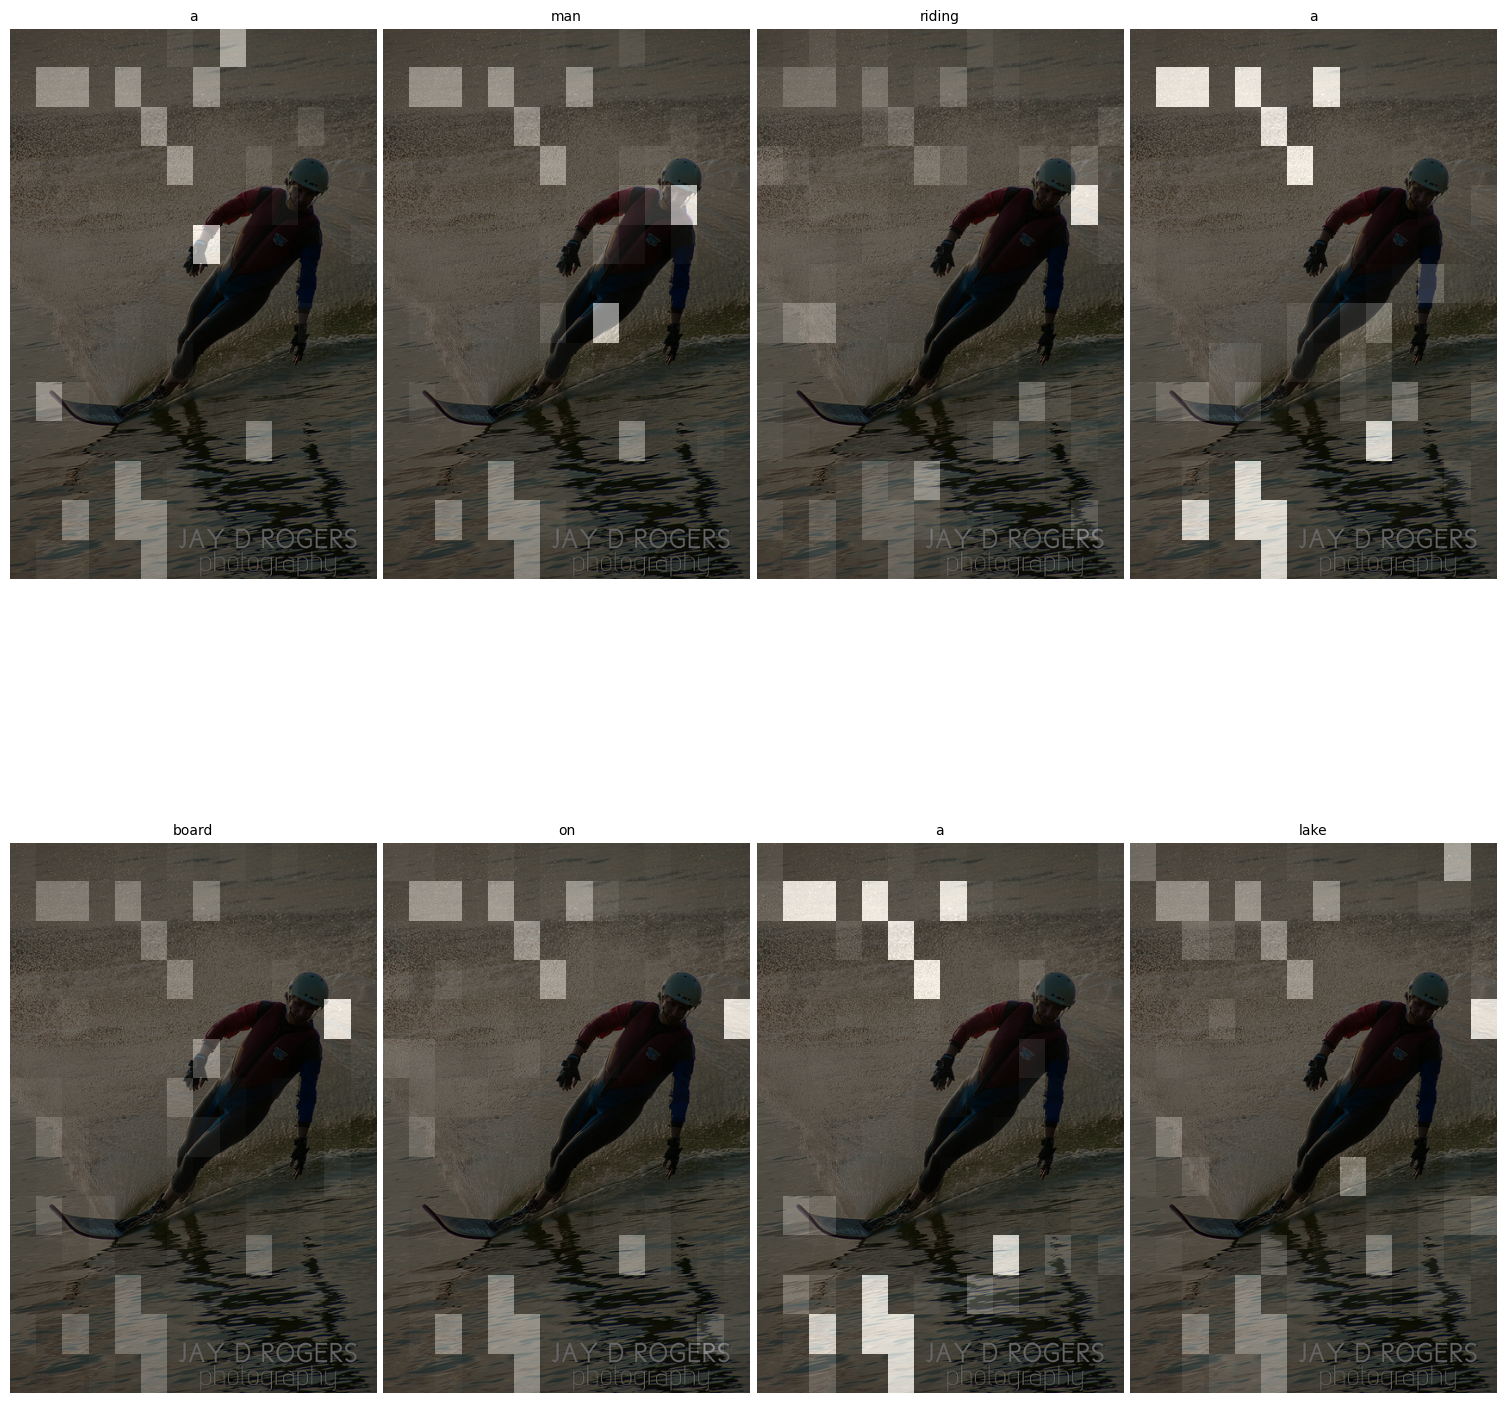

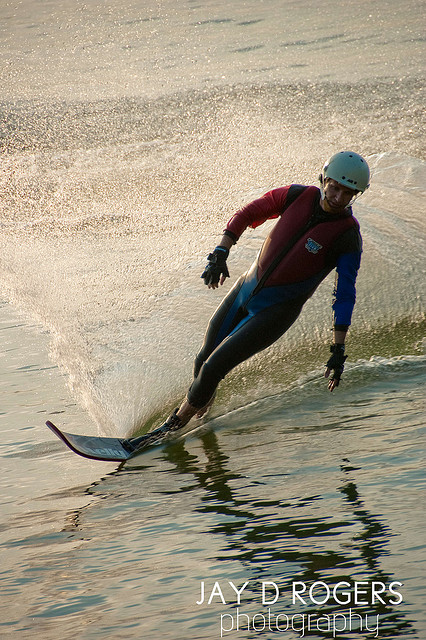


--- Evaluasi Gambar Kustom dengan Full Transformer ---
64400/64400 [==============================] - 0s 7us/step
Gambar kustom diunduh ke: /home/jupyter-c14220344@john.pet-5348a/new/my_test_image_transformer.jpg
Prediction (Custom): a man riding a wave on top of a surfboard


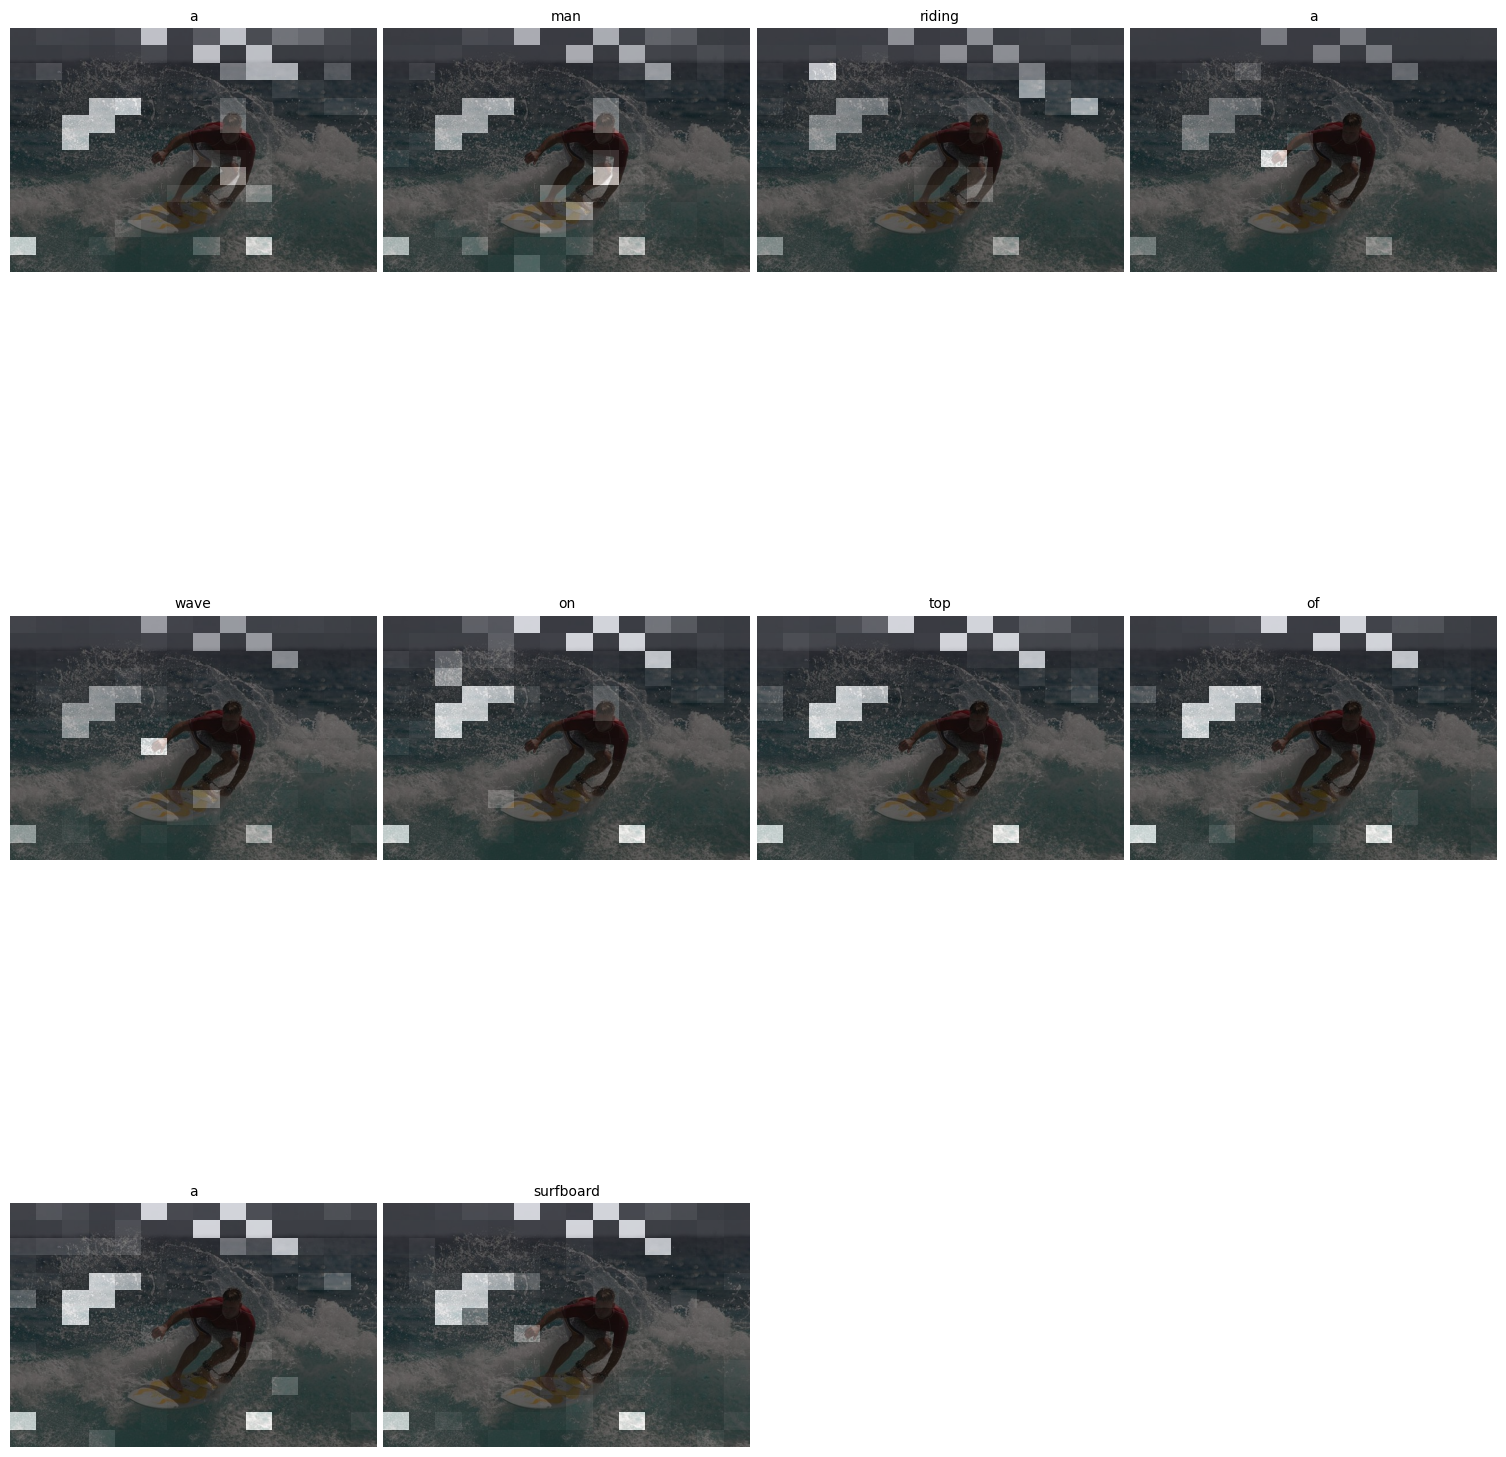

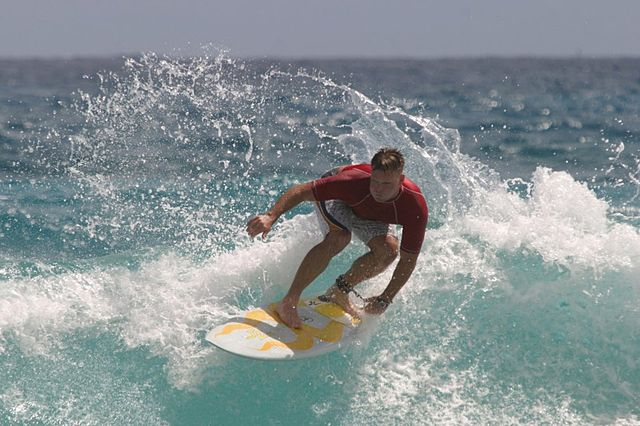

In [ ]:

if 'img_names_val_split' in locals() and len(img_names_val_split) > 0:
    rid_eval = np.random.randint(0, len(img_names_val_split))
    eval_image_path = img_names_val_split[rid_eval]
    eval_real_caption_tokens = [tokenizer.index_word.get(tok_id, "") for tok_id in caps_val_split[rid_eval] if tok_id != tokenizer.word_index['<pad>']]
    eval_real_caption = ' '.join(eval_real_caption_tokens).replace("<start>", "").replace("<end>", "").strip()

    print(f"\n--- Evaluasi Akhir Model Full Transformer ---")
    print(f"Gambar: {eval_image_path}")
    print(f"Real Caption    : {eval_real_caption}")

    eval_predicted_words, eval_attention_map = evaluate_caption_transformer(eval_image_path)
    eval_predicted_caption = ' '.join(eval_predicted_words)
    print(f"Predicted Caption: {eval_predicted_caption}")

    plot_attention_transformer_model(eval_image_path, eval_predicted_words, eval_attention_map)
    try:
        display(Image.open(eval_image_path))
    except NameError:
        Image.open(eval_image_path).show()

print(f"\n--- Evaluasi Gambar Kustom dengan Full Transformer ---")
custom_url = 'https://tensorflow.org/images/surf.jpg'
custom_ext = os.path.splitext(custom_url)[1] if os.path.splitext(custom_url)[1] else ".jpg"
try:
    my_custom_img_path = tf.keras.utils.get_file('my_test_image_transformer'+custom_ext, origin=custom_url, cache_subdir=os.path.abspath('.'))
    print(f"Gambar kustom diunduh ke: {my_custom_img_path}")
    custom_pred_words, custom_att_map = evaluate_caption_transformer(my_custom_img_path)
    print(f"Prediction (Custom): {' '.join(custom_pred_words)}")
    plot_attention_transformer_model(my_custom_img_path, custom_pred_words, custom_att_map)
    Image.open(my_custom_img_path).show()
except Exception as e_cust:
    print(f"Gagal memproses gambar kustom: {e_cust}")